In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import cell2location as c2l

import torch

In [2]:
adata_vis = sc.read("visium_d30_porta5_2.rds.h5ad")

In [ ]:
# Set sample name
adata_vis.obs['sample'] = 'Visium_d30_porta5'

# Set gene names
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('SYMBOL', drop=False, inplace=True)

In [ ]:
adata_vis.var['SYMBOL'] = adata_vis.var.index

In [ ]:
# Single cell reference data
adata_ref = sc.read("seurat.anotado_C2L.h5ad")
# Set gene names
adata_ref.var['SYMBOL'] = adata_ref.var.index

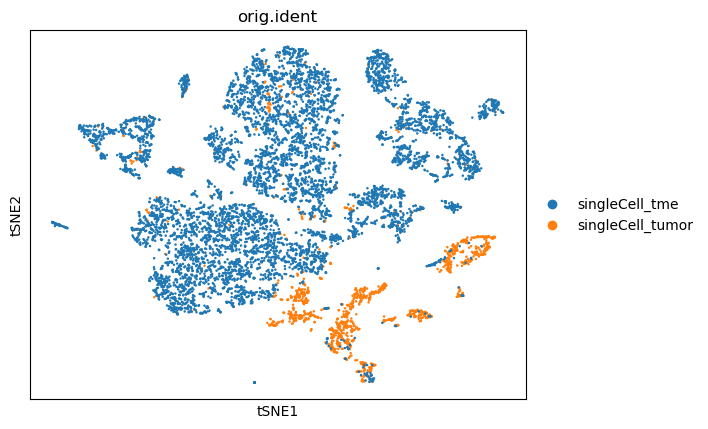

In [ ]:
adata_ref.X = adata_ref.layers["counts_SCT"]
sc.pl.tsne(adata_ref, color="orig.ident")

In [11]:
adata_vis.var.head()

names  SYMBOL  MT_gene
SYMBOL                         
Xkr4      Xkr4    Xkr4    False
Rp1        Rp1     Rp1    False
Sox17    Sox17   Sox17    False
Lypla1  Lypla1  Lypla1    False
Tcea1    Tcea1   Tcea1    False

C:\Users\itzia\miniconda3\envs\pit\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


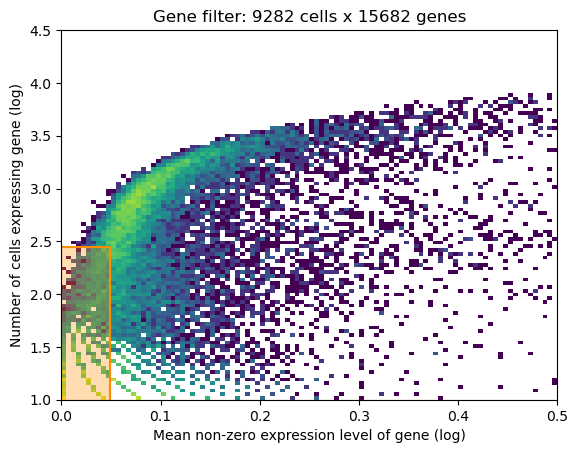

In [ ]:
# Filter genes from the reference object
selected = c2l.utils.filtering.filter_genes(
    adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12
)

In [ ]:
# Prepare reference for the regression model
c2l.models.RegressionModel.setup_anndata(adata=adata_ref,
                        batch_key='orig.ident',
                        labels_key='Final_Labels'
                       )

In [ ]:
# Regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'Final_Labels',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 9282  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  15   │
│          n_vars          │ 21609 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │  singleCell_tme  │          0          │
│                         │ singleCell_tumor │          1          │
└─────────────────────────┴──────────────────┴─────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Final_Labels'] │    Astrocytes     │          0          │
│                           │      B Cells      │          1          │
│                           │  Dendritic cells  │          2          │
│                           │ Endothelial cells │          3          │
│                           │  Ependymal cells  │          4          │
│                           │       ILCs        │          5          │
│                           │    Macrophages    │          6          │
│                           │     Microglia     │          7          │
│                           │     Monocytes     │          8          │
│                           │     NK cells      │          9          │
│                           │       NSCs        │         10          │
│                           │      Neurons      │         11          │
│                           │ Oligodendrocytes  │         12          │
│                           │      T cells      │         13          │
│                           │   Tumoral cells   │         14          │
└───────────────────────────┴───────────────────┴─────────────────────┘

In [ ]:
mod.train(max_epochs=250)

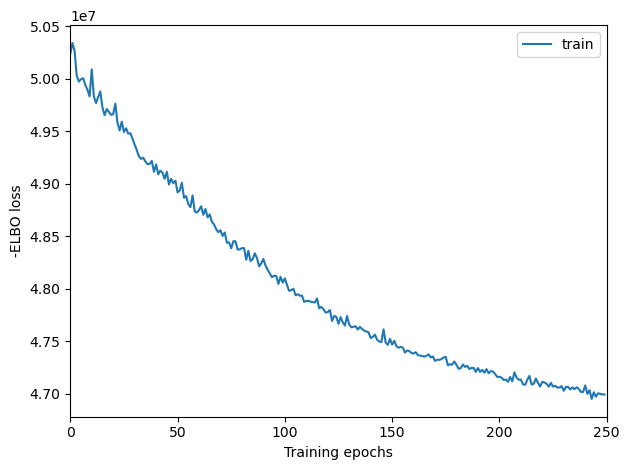

In [16]:
mod.plot_history()

In [ ]:
ref_run_name = "my_model_run_250_epoch_bueno"
# Estimated cell abundance
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 100, 'batch_size': 250}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

In [ ]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = c2l.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [ ]:
adata_ref = mod.export_posterior(
    adata_ref,
    sample_kwargs={'num_samples': 100, 'batch_size': 250}
)


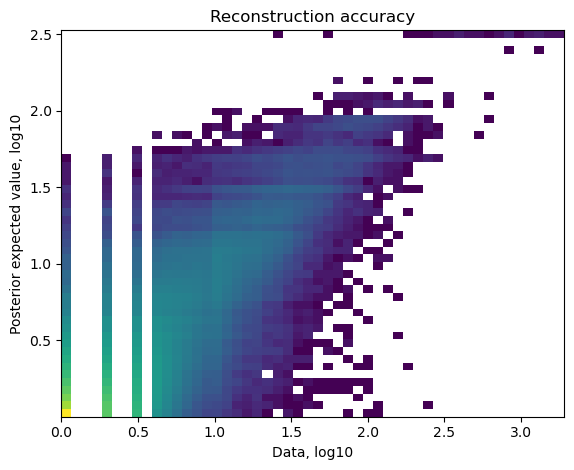

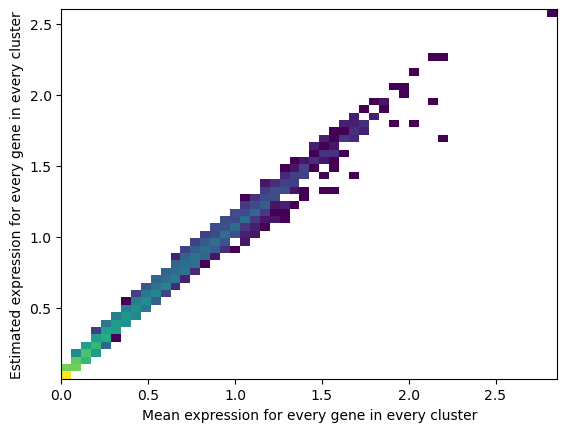

In [19]:
mod.plot_QC()

In [ ]:
ref_run_name = "my_model_run_250_epoch_bueno"
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = c2l.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [ ]:
# Export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Astrocytes   B Cells  Dendritic cells  Endothelial cells  \
Xkr4       0.055655  0.000836         0.013658           0.018162   
Gm1992     0.000783  0.000784         0.000791           0.000801   
Gm19938    0.000973  0.000845         0.000821           0.000850   
Rp1        0.000743  0.000887         0.000759           0.018473   
Sox17      0.000904  0.000787         0.000814           1.011205   

         Ependymal cells  
Xkr4            0.000730  
Gm1992          0.000753  
Gm19938         0.000683  
Rp1             0.000702  
Sox17           0.000851

In [ ]:
# Find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# Prepare query for cell2location model
c2l.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [ ]:
# Create and train the model
mod = c2l.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # Expected average cell abundance: tissue-dependent
    N_cells_per_location=14,
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2888  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15816 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                      batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Visium_d30_porta5 │          0          │
└─────────────────────┴───────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
mod.train(max_epochs=10000,
          # train using full data
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         )

# plot ELBO loss history during training
mod.plot_history()
plt.legend(labels=['full data training']);

In [ ]:
run_name = "my_model_run_2_10000_epoch"
mod = c2l.models.Cell2location.load(f"{run_name}", adata_vis)

In [ ]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 10, 'batch_size': mod.adata.n_obs}
)

In [ ]:
run_name = "my_model_run_2_10000_epoch_14_cellabund"
# Export the estimated cell abundance
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 10, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/9 [00:00<?, ?it/s]

'my_model_run_2_10000_epoch_14_cellabund/sp.h5ad'

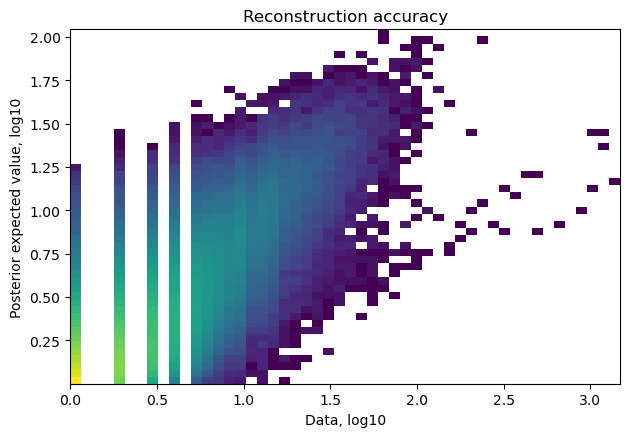

In [41]:
mod.plot_QC()

In [ ]:
from PIL import Image
import numpy as np

# Tissue image
image_path = "detected_tissue_image.jpg" 
tissue_image = Image.open(image_path)
image_flipud = np.flipud(tissue_image)
image_rotated = np.rot90(image_flipud, k=3)
# Image to array
tissue_image_array = np.array(image_rotated)

# Insert the image and the scale factor into query object
adata_vis.uns['spatial'] = {
    'Visium_d30_p5': { 
        'images': {
            'hires': tissue_image_array 
        },
        'scalefactors': {
            'spot_diameter_fullres': 15.02406,  
            'tissue_hires_scalef': 1 
        },
        'metadata': {
            'chemistry_description': 'Custom',
            'software_version': 'Manual'
        }
    }
}

In [ ]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
adata_vis.obs['library_id'] = 'Visium_d30_p5'
slide = adata_vis[adata_vis.obs['library_id'] == 'Visium_d30_p5'].copy()
slide.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obs.loc[slide.obs.index, adata_vis.uns['mod']['factor_names']]

C:\Users\itzia\AppData\Local\Temp\ipykernel_5076\3853471806.py:14: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(slide, cmap="magma",


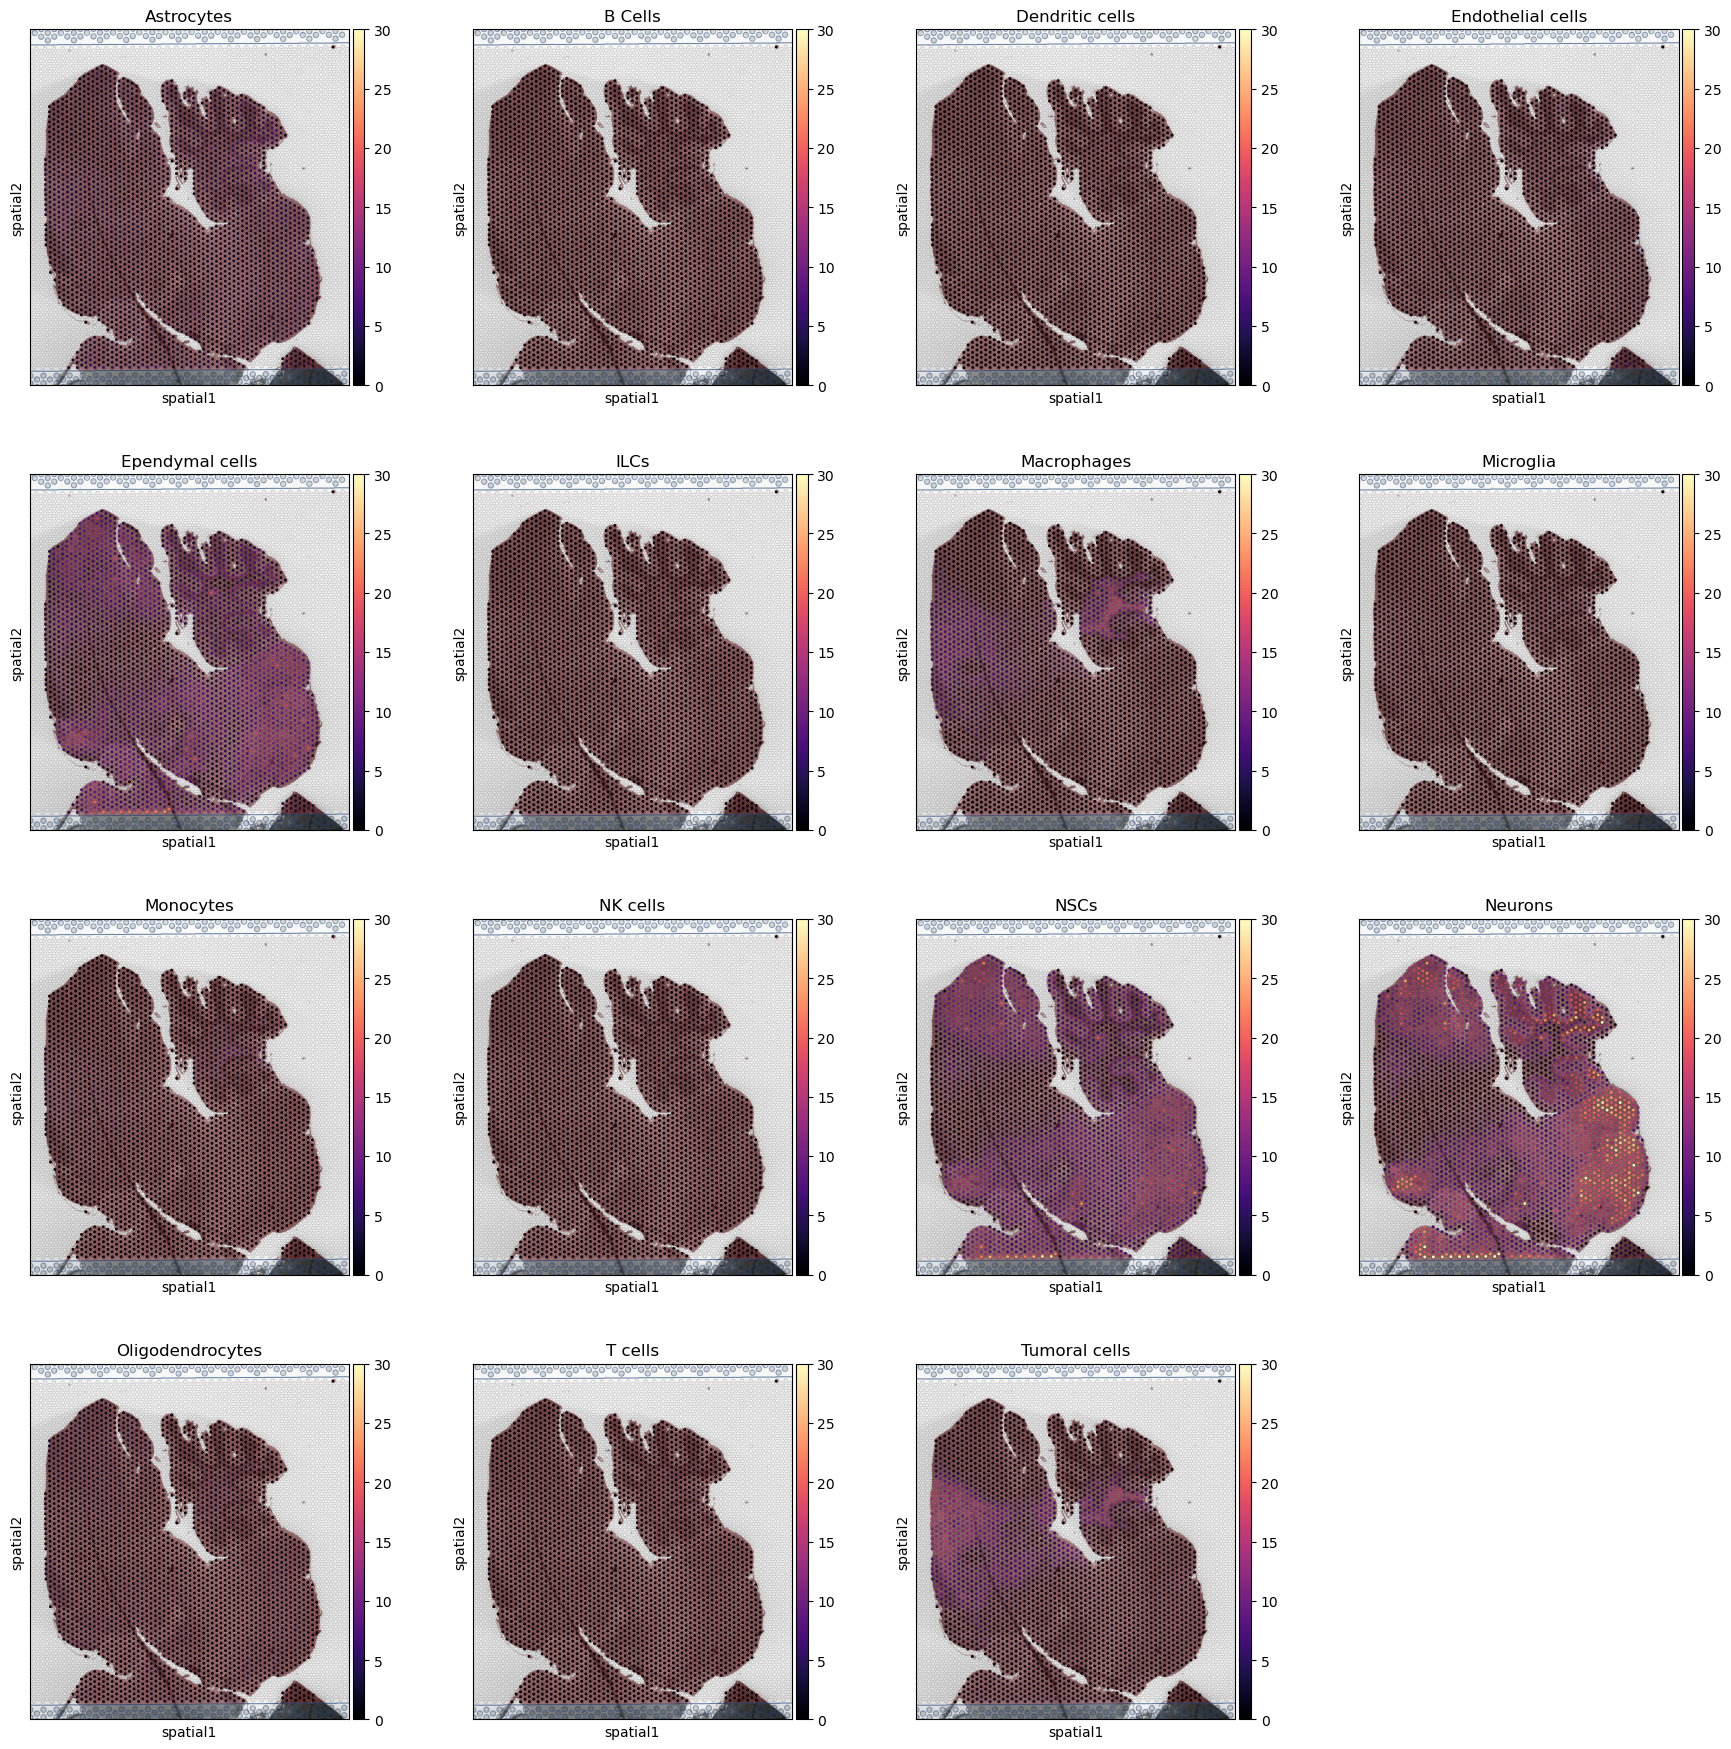

In [ ]:
import matplotlib as mpl
# Plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
#magma, viridis, plasma, inferno, cividis
    sc.pl.spatial(slide, cmap="magma",
                  color=adata_vis.uns['mod']['factor_names'],
                  ncols=4, size=0.8,
                  img_key='hires',
                  vmin=0, vmax=30,
                  save="spatial_plot.png"
                 )